### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [6]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
#using Distributions
using MDToolbox

In [7]:
function _mbar_f(u_kl, f_k, u_k=nothing)
    # K: number of umbrella windows
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = zeros(Float64, K, K, N_max)
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end

    # conversion from cell (u_k) to array (u_kn)
    u_kn = zeros(Float64, K, N_max)
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= zero(Float64)
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end

    log_w_kn = zeros(Float64, K, N_max)
    for k = 1:K
      log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5;

    log_w_kn = MDToolbox.mbar_log_wi_jn(N_k, f_k, u_kln, u_kn, K, N_max)
    f_hat = - MDToolbox.logsumexp_1d(log_w_kn[idx])

    return f_hat
end

_mbar_f (generic function with 2 methods)

In [41]:
function ChainRulesCore.rrule(::typeof(_mbar_f), u_kl, f_k, u_k)
    f_hat = _mbar_f(u_kl, f_k, u_k)
    w_k = MDToolbox.mbar_weight(u_kl, f_k, u_k)
    function _mbar_f_pullback(df)
        println("size(df):$(size(df, 1))")
        du_k = deepcopy(w_k)
        exp_minus_f_hat = exp(-f_hat)
        for k = 1:length(w_k)
            for n = 1:length(w_k[k])
                du_k[k][n] = exp_minus_f_hat * w_k[k][n] * df
            end
        end
        println("size(du_k):$(size(du_k))")
        println("size(du_k[1]:$(size(du_k[1]))")
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return f_hat, _mbar_f_pullback
end

In [9]:
MDToolbox.mbar_log_wi_jn

mbar_log_wi_jn (generic function with 1 method)

In [43]:
u_kl[1:2,1:2]

2×2 Matrix{Vector{Float64}}:
 [-0.59431, -0.588658, -0.710982, -0.643933, -0.666662, -0.625228, -0.678706, -0.760248, -0.704786, -0.589452  …  -2.97276, -2.98334, -2.98506, -2.9744, -2.97762, -2.95988, -2.97292, -2.97166, -2.97553, -2.96331]  …  [-1.5319, -1.5285, -1.52871, -1.53061, -1.53238, -1.53254, -1.53334, -1.53431, -1.53102, -1.52636  …  -1.5066, -1.50231, -1.49757, -1.49763, -1.49979, -1.50153, -1.50545, -1.50282, -1.50523, -1.51286]
 [-1.94763, -2.02028, -1.95286, -1.91056, -1.9953, -2.00608, -2.12319, -2.17776, -2.21832, -2.39937  …  -2.96312, -2.94941, -2.94396, -2.97569, -2.94463, -2.96481, -2.99418, -2.9786, -3.00584, -3.01174]               [-2.30618, -2.30602, -2.30833, -2.31526, -2.30632, -2.30404, -2.29546, -2.29619, -2.29516, -2.2852  …  -1.93216, -1.93823, -1.93145, -1.92291, -1.92799, -1.92089, -1.91501, -1.91929, -1.91795, -1.90893]

### ポテンシャルエネルギー関数の定義

In [10]:
#2原子の距離を用いポテンシャルを計算
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

#nステップ目のポテンシャルを計算
function sum_compute_energy(coords, epsilon, sigma)
    U = 0
    for i in 1:size(coords, 1)
        for j in (i+1):size(coords, 1)
            U += compute_energy(coords[i], coords[j], epsilon, sigma)
        end
    end
    return U
end

sum_compute_energy (generic function with 1 method)

In [11]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        println("size(dU):$(size(dU))")
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [12]:
#n原子の軌跡からFを計算
#coords_trj = data_k[i]
function compute_free_energy(coords_trj, beta, epsilon, sigma)
    N = size(coords_trj, 1) #ステップ数
    U_array = [sum_compute_energy(coords_trj[i], epsilon, sigma) for i in 1:N] #Nステップのポテンシャルの値を入れた配列
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array)) #U_arrayを積分してFを計算
    return F
end

compute_free_energy (generic function with 1 method)

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [13]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(coords, u_kl, f_k) = _mbar_f(u_kl, f_k, [sum_compute_energy(coords[i], m.P[1], m.P[2]) for i in 1:size(coords, 1)])

In [14]:
# カスタムレイヤでポテンシャルエネルギー値を計算できるかテスト
m = Energy([1.0, 1.0])
coords = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
m(coords)

LoadError: MethodError: no method matching (::Energy)(::Vector{Vector{Float64}})

[0mClosest candidates are:
[0m  (::Energy)(::Any, [91m::Any[39m, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[13]:7[24m[39m


### MCMCの定義

In [15]:
#次のステップ候補点
function next_coords(coords, delta_x=1e-2)
    next_coords = map(x -> x .+ (rand(3) .- 0.5) .* delta_x, coords)
    return next_coords
end

next_coords (generic function with 2 methods)

In [16]:
#MCMC,メトロポリス法
function mcmc(coords, epsilon, sigma, nstep=100, beta=1.0, delta_x=1e-2)
    coords_trj = []
    alpha_trj = []
    push!(coords_trj, copy.(coords))
    
    for i in 1:nstep
        next_coords_tmp = next_coords(coords, delta_x) #候補点
        delta_U = sum_compute_energy(next_coords_tmp, epsilon, sigma) - sum_compute_energy(coords, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords = next_coords_tmp
        end     
        push!(coords_trj, copy.(coords))
        push!(alpha_trj, alpha)
    end
    return coords_trj, alpha_trj
end

mcmc (generic function with 4 methods)

### 訓練データの作成

In [17]:
#パラメータ
param_set = [(1.3, 2.3),(1.0, 2.0),(1.2, 2.5)] #params_set[i] = (epsilon[i], sigma[i])

data_k = []
alpha_trj = []
K = size(param_set, 1) #最後のパラメータの値を推定する
natom = 4
kBT = 2.0
beta = 1.0/(kBT)
nstep = 10000
delta_x = 1e-2

for i in 1:size(param_set, 1)
    use_param = i #使うパラメータ
    epsilon = param_set[use_param][1]
    sigma = param_set[use_param][2]

    coords = [[[sigma * x + rand(), rand(), rand()] for x in 1:natom]...]  #初期座標

    #nstepのMCMC
    coords_trj, alpha = mcmc(coords, epsilon, sigma, nstep, beta, delta_x)
    push!(data_k, coords_trj)
    push!(alpha_trj, alpha)
end

In [18]:
alpha_trj[1]

10000-element Vector{Any}:
 0.9621721996362216
 0.8602939036605964
 1.0947692991134694
 0.8726508463729475
 0.8085748830502234
 0.642828982500485
 0.5992467094220902
 1.0999613857348862
 0.7175728050453148
 0.5944125963942706
 1.1686681796569218
 0.7383957400569087
 0.7259085758999605
 ⋮
 0.9962554273955125
 1.0062926189418855
 0.9957313734474537
 1.0006653740966176
 1.000157705284137
 1.0001163513474247
 0.9953148251523456
 1.0068788770976096
 0.9997121514807836
 0.9993760297210927
 0.9970501691612949
 0.9969511351243425

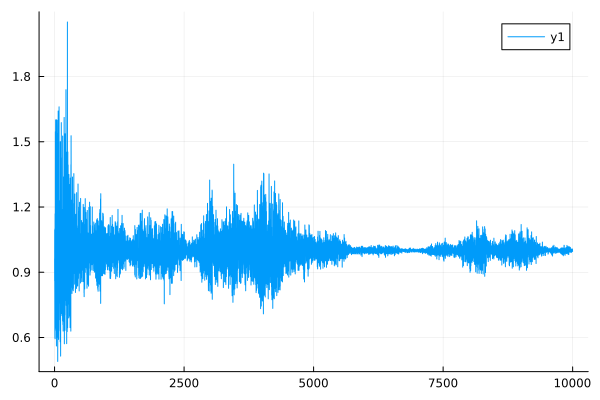

In [19]:
plot(alpha_trj[1][1:end])

In [20]:
#シミュレーションのパラメータ
#epsilon = param_set[i][1]
#sigma = param_set[i][2]

#実験のパラメータ,分かっていないものとして考える
epsilon_target = param_set[end][1]
sigma_target = param_set[end][2]

2.5

In [21]:
#FとF_targetを数値積分で計算
F = [compute_free_energy(data_k[i], beta, param_set[i][1], param_set[i][2]) for i in 1:K-1] 
F_target = compute_free_energy(data_k[end], beta, epsilon_target, sigma_target)

#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
#X_train = data_k[1:K-1]    #シミュレーションの座標
#y_train = F_target .- F #自由エネルギー差

-2.166125859666

### MBAR

In [22]:
u_kl = Matrix{Vector{Float64}}(undef, (K, K))
nstep = size(data_k[1], 1)

for k in 1:K
    for l in 1:K #F_targetもMBARで推定する
        #k番目のtrjデータをl番目のパラメータを用いポテンシャルを計算
        #xは何ステップ目を表す変数
        u_kl[k, l] = [sum_compute_energy(data_k[k][x], param_set[l][1], param_set[l][2]) for x in 1:nstep]
    end
end      

In [23]:
# solve MBAR equations
f_k = mbar(u_kl)

iteration = 1  delta = 1.645084e+00  tol = 1.000000e-08
free energies =  0.000000 -0.129625 1.312416

iteration = 2  delta = 3.579482e-01  tol = 1.000000e-08
free energies =  0.000000 -0.390689 1.712935

iteration = 3  delta = 1.629283e-01  tol = 1.000000e-08
free energies =  0.000000 -0.591449 1.927549

iteration = 4  delta = 9.741882e-02  tol = 1.000000e-08
free energies =  0.000000 -0.732780 2.064939

iteration = 5  delta = 6.394539e-02  tol = 1.000000e-08
free energies =  0.000000 -0.831473 2.158698

iteration = 6  delta = 4.308610e-02  tol = 1.000000e-08
free energies =  0.000000 -0.900783 2.224420

iteration = 7  delta = 2.962321e-02  tol = 1.000000e-08
free energies =  0.000000 -0.949809 2.271093

iteration = 8  delta = 2.066990e-02  tol = 1.000000e-08
free energies =  0.000000 -0.984703 2.304478

iteration = 9  delta = 1.457690e-02  tol = 1.000000e-08
free energies =  0.000000 -1.009658 2.328462

iteration = 10  delta = 1.035881e-02  tol = 1.000000e-08
free energies =  0.000000

3-element Vector{Float64}:
  0.0
 -1.074032641876313
  2.390833663653381

In [24]:
for i in 1:K-1
    println("F_$(i) = $(F[i]-F[1])")
end
println("F_target = $(F_target-F[1])")
println()

println("MBAR")
for i in 1:K-1
    println("F_$(i) = $(f_k[i])")
end
println("F_target = $(f_k[end])")

F_1 = 0.0
F_2 = -0.8264779321997509
F_target = -0.8966504878834733

MBAR
F_1 = 0.0
F_2 = -1.074032641876313
F_target = 2.390833663653381


In [25]:
X_train = []
push!(X_train, data_k[1])
push!(X_train, u_kl[1:end-1, 1:end-1]) 
y_train = f_k[end]

2.390833663653381

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [26]:
# Lossの定義
m = Energy([1.0, 2.0])
loss(X, y) = Flux.Losses.mse(m(X[1], X[2], f_k[1:end-1]), y) #X[1] = data_k[1], X[2] = u_kl[1:end-1, 1:end-1]
loss(X_train, y_train)

18.7517150453131

In [27]:
m(data_k[1], u_kl[1:2, 1:2], f_k[1:2])

-1.9394913871151065

In [28]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3) 

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [29]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [42]:
# 訓練
loss_train = []

for epoch in 1:11
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    push!(loss_train, loss(X_train, y_train))
    if epoch%10 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

size(df):1
size(du_k):(2,)
size(du_k[1]:(10001,)
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
siz

Excessive output truncated after 524293 bytes.

size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size(dU):()
size

In [36]:
loss(X_train, y_train)

0.027496408053224175

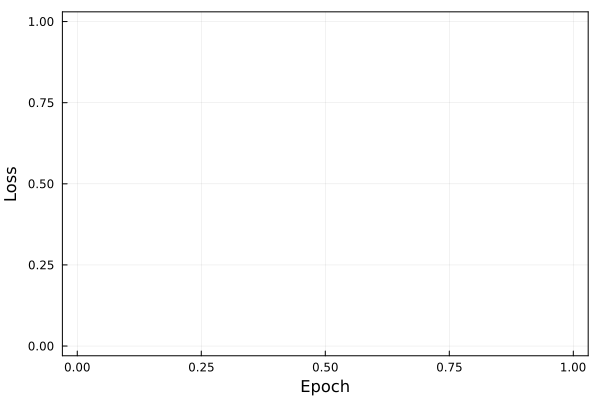

In [37]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [38]:
println("Ground-truth epsilon: ", epsilon_true)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_true)
println("Estimate sigma:     ", m.P[2])

LoadError: UndefVarError: `epsilon_true` not defined

In [39]:
1/(sum(sum(a)))

LoadError: UndefVarError: `a` not defined